# Text Features and Embeddings In CatBoost

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/events/2020_11_18_catboost_tutorial/text_embedding_features.ipynb)


**Set GPU as hardware accelerator**

First of all, you need to select GPU as hardware accelerator. There are two simple steps to do so:
Step 1. Navigate to **Runtime** menu and select **Change runtime type**
Step 2. Choose **GPU** as hardware accelerator.
That's all!

Let's install CatBoost.

In [3]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import catboost
print(catboost.__version__)

0.26.1


Youtube [tutorial](https://youtu.be/lB0WYoz5nU4?t=2029)

# Preparing data

In this tutorial we will use dataset **IMDB** from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

In [4]:
df = pd.read_csv('imdb.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df['label'] = (df['sentiment'] == 'positive').astype(int)
df.drop(['sentiment'], axis=1, inplace=True)
df.head()

,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


<AxesSubplot:ylabel='Frequency'>

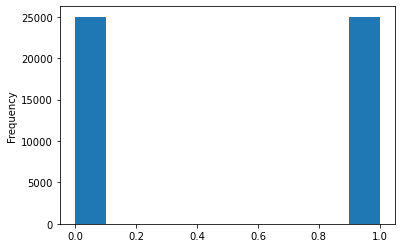

In [6]:
df.label.plot.hist()

In [7]:
from catboost import Pool
from sklearn.model_selection import train_test_split

# train test split
train_df, test_df = train_test_split(df, train_size=0.8, random_state=0)

# split targets and text
y_train, X_train = train_df['label'], train_df.drop(['label'], axis=1)
y_test, X_test = test_df['label'], test_df.drop(['label'], axis=1)

<AxesSubplot:ylabel='Frequency'>

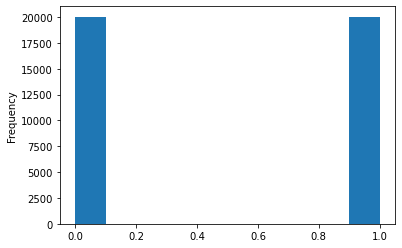

In [8]:
y_train.plot.hist()

<AxesSubplot:ylabel='Frequency'>

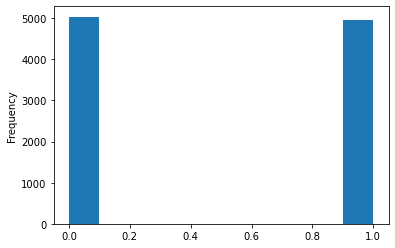

In [9]:
y_test.plot.hist()

In [10]:
# for simplicity create pools instead of every time passing X,y
train_pool = Pool(data=X_train, label=y_train, text_features=['review'])
test_pool = Pool(data=X_test, label=y_test, text_features=['review'])

print('Train dataset shape: {}\n'.format(train_pool.shape))

Train dataset shape: (40000, 1)



**Baseline**, without preprocessing.

In [11]:
from catboost import CatBoostClassifier

def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=1200,
        learning_rate=0.1,
        eval_metric='AUC',
        custom_loss=['AUC', 'Accuracy'],
        leaf_estimation_method='Newton',
        l2_leaf_reg=5,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=False,
        plot=True,
    )

# can specify task_type='GPU'
# in Colab task_type='GPU' will not work with plotting
model = fit_model(train_pool, test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Just for the record:
* AUC = 0.9559
* Accuracy = 0.8961

**How it works?**
There are three main steps when dealing with text features.

1. **Text Tokenization**
2. **Dictionary Creation**
3. **Feature Calculation**

## Text Tokenization

Usually we get our text as a sequence of Unicode symbols. So, if the task isn't a DNA classification we don't need such granularity, moreover, we need to extract more complicated entities, e.g. words. The process of extraction tokens -- words, numbers, punctuation symbols or special symbols which defines emoji from a sequence is called **tokenization**.<br>

Tokenization is the first part of text preprocessing in CatBoost and performed as a simple splitting a sequence on a string pattern (e.g. space).

In [10]:
text_small = [
    "Cats are so cute :)",
    "Mouse scare...",
    "The cat defeated the mouse",
    "Cute: Mice gather an army!",
    "Army of mice defeated the cat :(",
    "Cat offers peace",
    "Cat is scared :(",
    "Cat and mouse live in peace :)"
]

target_small = [1, 0, 1, 1, 0, 1, 0, 1]

We start with simple tokenizer with default parameters, they are passed explicetely. Some interesting parameters are
* `number_process_policy` - The strategy to process numeric tokens. Possible values:
    * Skip — Skip all numeric tokens.
    * LeaveAsIs — Leave all numeric tokens as is.
    * Replace — Replace all numeric tokens with a single special token. This token in specified in the number_token parameter.

* `number_token` - The special token that is used to replace all numeric tokens with. This option can be used if the selected numeric tokens processing strategy is Replace.

* `separator_type` - The tokenization method. Possible values:
    * ByDelimiter — Split by delimiter (default).
    * BySense — Try to split the string by sense.
* `split_by_set` - Use each single character in the `delimiter` option as an individual delimiter
* `token_types` - The types of tokens that should be kept after the tokenization. Should be used if the separator_type parameter is set to BySense. Possible values (by default all supported types of tokens are kept):
    * Word
    * Number
    * Punctuation
    * SentenceBreak
    * ParagraphBreak
    * Unknown
* `sub_tokens_policy` - The subtokens processing policy. Should be used if the separator_type parameter is set to BySense. Possible values:
    * SingleToken — All subtokens are interpreted as a single token (default).
    * SeveralTokens — All subtokens are interpreted as several tokens.


In [11]:
from catboost.text_processing import Tokenizer

simple_tokenizer = Tokenizer(
    lowercasing=False,
    lemmatizing=False,
    number_process_policy='LeaveAsIs',
    number_token=None,  # Numeric tokens are left as is
    separator_type='ByDelimiter',
    delimiter=' ',
    split_by_set=False,
    skip_empty=True,
    token_types=None,
    sub_tokens_policy=None,
    languages=None
)
    
def tokenize_texts(texts):
    return [simple_tokenizer.tokenize(text) for text in texts]

simple_tokenized_text = tokenize_texts(text_small)
simple_tokenized_text

[['Cats', 'are', 'so', 'cute', ':)'],
 ['Mouse', 'scare...'],
 ['The', 'cat', 'defeated', 'the', 'mouse'],
 ['Cute:', 'Mice', 'gather', 'an', 'army!'],
 ['Army', 'of', 'mice', 'defeated', 'the', 'cat', ':('],
 ['Cat', 'offers', 'peace'],
 ['Cat', 'is', 'scared', ':('],
 ['Cat', 'and', 'mouse', 'live', 'in', 'peace', ':)']]

Lets take a closer look on the tokenization result of small text example -- the tokens contains a lot of mistakes:

1. They are glued with punctuation 'Cute:', 'army!', 'skare...'.
2. The words 'Cat' and 'cat', 'Mice' and 'mice' seems to have same meaning, perhaps they should be the same tokens.
3. The same problem with tokens 'are'/'is' -- they are inflected forms of same token 'be'.

**Punctuation handling**, **lowercasing**, and **lemmatization** processes help to overcome these problems.

### Punctuation handling and lowercasing

In [12]:
tokenizer = Tokenizer(
    lowercasing=True,
    separator_type='BySense',
    token_types=['Word', 'Number']
)

tokenized_text = [tokenizer.tokenize(text) for text in text_small]
tokenized_text

[['cats', 'are', 'so', 'cute'],
 ['mouse', 'scare'],
 ['the', 'cat', 'defeated', 'the', 'mouse'],
 ['cute', 'mice', 'gather', 'an', 'army'],
 ['army', 'of', 'mice', 'defeated', 'the', 'cat'],
 ['cat', 'offers', 'peace'],
 ['cat', 'is', 'scared'],
 ['cat', 'and', 'mouse', 'live', 'in', 'peace']]

### Removing stop words

**Stop words** - the words that are considered to be uninformative in this task, e.g. function words such as *the, is, at, which, on*.
Usually stop words are removed during text preprocessing to reduce the amount of information that is considered for further algorithms.
Stop words are collected manually (in dictionary form) or automatically, for example taking the most frequent words.

In [13]:
stop_words = set(('be', 'is', 'are', 'the', 'an', 'of', 'and', 'in'))

def filter_stop_words(tokens):
    return list(filter(lambda x: x not in stop_words, tokens))
    
tokenized_text_no_stop = [filter_stop_words(tokens) for tokens in tokenized_text]
tokenized_text_no_stop

[['cats', 'so', 'cute'],
 ['mouse', 'scare'],
 ['cat', 'defeated', 'mouse'],
 ['cute', 'mice', 'gather', 'army'],
 ['army', 'mice', 'defeated', 'cat'],
 ['cat', 'offers', 'peace'],
 ['cat', 'scared'],
 ['cat', 'mouse', 'live', 'peace']]

### Lemmatization

Lemma (Wikipedia) -- is the canonical form, dictionary form, or citation form of a set of words.<br>
For example, the lemma "go" represents the inflected forms "go", "goes", "going", "went", and "gone".<br>
The process of convertation word to its lemma called **lemmatization**.


In [14]:
import nltk

nltk_data_path = os.path.join(os.path.dirname(nltk.__file__), 'nltk_data')
nltk.data.path.append(nltk_data_path)
nltk.download('wordnet', nltk_data_path)

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_tokens_nltk(tokens):
    return list(map(lambda t: lemmatizer.lemmatize(t), tokens))

[nltk_data] Downloading package wordnet to
[nltk_data]     /opt/anaconda3/envs/catboost/lib/python3.9/site-
[nltk_data]     packages/nltk/nltk_data...


In [18]:
nltk.download('omw-1.4')
text_small_lemmatized_nltk = [lemmatize_tokens_nltk(tokens) for tokens in tokenized_text_no_stop]
text_small_lemmatized_nltk

[nltk_data] Downloading package omw-1.4 to /home/stankvla/nltk_data...


[['cat', 'so', 'cute'],
 ['mouse', 'scare'],
 ['cat', 'defeated', 'mouse'],
 ['cute', 'mouse', 'gather', 'army'],
 ['army', 'mouse', 'defeated', 'cat'],
 ['cat', 'offer', 'peace'],
 ['cat', 'scared'],
 ['cat', 'mouse', 'live', 'peace']]

Now words with same meaning represented by the same token, tokens are not glued with punctuation.

<span style="color:red">Be carefull.</span> You should verify for your own task:<br>
Is it realy necessary to remove punctuation, lowercasing sentences or performing a lemmatization and/or by word tokenization?<br>

### Let's check up accuracy with new text preprocessing

Since CatBoost doesn't perform spacing punctuation, lowercasing letters and lemmatization, we need to preprocess text manually and then pass it to learning algorithm.

Since the natural text features is only synopsis and review, we will preprocess only them.

In [19]:
%%time

tokenizer = Tokenizer(
    lowercasing=True,
    separator_type='BySense',
    token_types=['Word', 'Number']
)

def preprocess_data(X):
    X_preprocessed = X.copy()
    X_preprocessed['review'] = X['review'].apply(lambda x: ' '.join(lemmatize_tokens_nltk(tokenizer.tokenize(x))))
    return X_preprocessed

X_preprocessed_train = preprocess_data(X_train)
X_preprocessed_test = preprocess_data(X_test)

train_processed_pool = Pool(
    X_preprocessed_train, y_train, 
    text_features=['review'],
)

test_processed_pool = Pool(
    X_preprocessed_test, y_test, 
    text_features=['review'],
)

CPU times: user 29.4 s, sys: 51.4 ms, total: 29.5 s
Wall time: 29.5 s


In [21]:
model_on_processed_data = fit_model(train_processed_pool, test_processed_pool)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Now we obtained the following results:
* AUC = 0.9669
* Accuracy = 0.9049

In [29]:
def print_score_diff(first_model, second_model, metric_name):
    first_accuracy = first_model.best_score_['validation'][metric_name]
    second_accuracy = second_model.best_score_['validation'][metric_name]

    gap = (second_accuracy - first_accuracy) / first_accuracy * 100

    print('{:8} :: {:.4f} vs {:.4f} ({:+.2f}%)'.format(metric_name, first_accuracy, second_accuracy, gap))
    
print_score_diff(model, model_on_processed_data, 'AUC')
print_score_diff(model, model_on_processed_data, 'Accuracy')

AUC      :: 0.9594 vs 0.9670 (+0.79%)
Accuracy :: 0.8961 vs 0.9049 (+0.98%)


## Dictionary Creation

The second stage uses the prepared text to select a set of units, which will be used for building new numerical features.

A set of selected units is called dictionary. It might contain words, word bigramms, or character n-gramms.

In [30]:
from catboost.text_processing import Dictionary

In [31]:
text_small_lemmatized_nltk

[['cat', 'so', 'cute'],
 ['mouse', 'scare'],
 ['cat', 'defeated', 'mouse'],
 ['cute', 'mouse', 'gather', 'army'],
 ['army', 'mouse', 'defeated', 'cat'],
 ['cat', 'offer', 'peace'],
 ['cat', 'scared'],
 ['cat', 'mouse', 'live', 'peace']]

Creating **Dictionary**, [docs](https://catboost.ai/en/docs/concepts/python-reference_dictionary), interesting parameters are the following:
* `token_level_type`: Word(default) or Letter
* `gram_order`: int, (1 is default), can be used for words and letters
* `skip_step`: nt, (0 is default), gram_order should be > 1, 
    * if `skip_step=1, gram_order=2` than in sequence w1 w2 w3 w4 we would generate the following bigrams
    * `[w1, w3]` and `[w2, w4]`, hence skipping one word in the bigram
* `occurence_lower_bound`: The lower limit of token occurrences in the text to include it in the dictionary. Default is 50.
* `max_dictionary_size`: The maximum number of tokens in the dictionary. Default is -1 (unlimited).
* `dictionary_type`: Possible values:
    * FrequencyBased (default). Takes into account only the most frequent tokens. The size of the dictionary and the lower limit of token occurrences in the text to include it in the dictionary are set in `occurence_lower_bound` and `max_dictionary_size` parameters respectively.
    * Bpe. Takes into account the most frequent tokens and then makes new tokens from combinations of the most frequent token pairs. If selected, both the Frequency Based and Bpe dictionaries are created.
* `num_bpe_units`: The number of token pairs that should be combined to a single token. The most popular tokens are combined into one and added to the dictionary as a new token (if `dictionary_type='Bpe'`). Default is 0.
* `skip_unknown`: Skip unknown tokens when building the dictionary (if `dictionary_type='Bpe'`). Default is False



In [42]:
dictionary = Dictionary(
    token_level_type='Word',
    gram_order=1,
    skip_step=0,
    occurence_lower_bound=2
)

dictionary.fit(text_small_lemmatized_nltk)
#dictionary.fit(text_small, tokenizer)

In [43]:
dictionary.save('dictionary.tsv')
!cat dictionary.tsv

{"end_of_word_token_policy":"Insert","skip_step":"0","start_token_id":"0","token_level_type":"Word","dictionary_format":"id_count_token","end_of_sentence_token_policy":"Skip","gram_order":"1"}
6
0	6	cat
1	5	mouse
2	2	army
3	2	cute
4	2	defeated
5	2	peace


In [44]:
# apply dictionary on the first sentence
dictionary.apply([text_small_lemmatized_nltk[0]])

[[0, 3]]

## Feature Calculation

### Convertation into fixed size vectors

The majority of classic ML algorithms are computing and performing predictions on a fixed number of features $N$.<br>
That means that learning set $X = \{x_i\}$ contains vectors $x_i = (a_0, a_1, ..., a_N)$ where $N$ is constant.

Since text object $x$ is not a fixed length vector, we need to perform preprocessing of the origin set $D$.<br>
One of the simplest text to vector encoding technique is **Bag of words (BoW)**.

### Bag of words algorithm

The algorithm takes in a dictionary and a text.<br>
During the algorithm text $x = (a_0, a_1, ..., a_k)$ converted into vector $\tilde x = (b_0, b_1, ..., b_F)$,<br> where $b_i$ is 0/1 (depending on whether there is a word with id=$i$ from dictionary into text $x$).

In [46]:
simple_tokenizer = Tokenizer(
    lowercasing=False,
    lemmatizing=False,
    number_process_policy='LeaveAsIs',
    number_token=None,  # Numeric tokens are left as is
    separator_type='ByDelimiter',
    delimiter=' ',
    split_by_set=False,
    skip_empty=True,
    token_types=None,
    sub_tokens_policy=None,
    languages=None
)
N = 1000

# create small training set
X_proc_train_small, y_train_small = X_preprocessed_train[:N]['review'].to_list(), y_train[:N]
# tokenize using simple tokenizer
X_proc_train_small = list(map(simple_tokenizer.tokenize, X_proc_train_small))

# create small validation set
X_proc_test_small, y_test_small = X_preprocessed_test[:N]['review'].to_list(), y_test[:N]
# tokenize using simple tokenizer
X_proc_test_small = list(map(simple_tokenizer.tokenize, X_proc_test_small))

dictionary = Dictionary(max_dictionary_size=100)
dictionary.fit(X_proc_train_small);

In [47]:
type(X_proc_train_small)

list

In [48]:
# create bag of words features
def bag_of_words(tokenized_text, dictionary):
    features = np.zeros((len(tokenized_text), dictionary.size))
    for i, tokenized_sentence in enumerate(tokenized_text):
        # here we take 0th object since dictionary returns list of lists
        # in our case it is a list of one element (encoded sentence)
        indices = np.array(dictionary.apply([tokenized_sentence])[0])
        if len(indices) > 0:
            # for every index set 1
            features[i, indices] = 1
    return features

X_bow_train_small = bag_of_words(X_proc_train_small, dictionary)
X_bow_test_small = bag_of_words(X_proc_test_small, dictionary)
X_bow_train_small.shape

(1000, 100)

Now we will see how dictionary size can effect model performance. We will use simple logistic regression model.

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_auc_score

def fit_linear_model(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    return model


def evaluate_model_auc(model, X, y):
    y_pred = model.predict_proba(X)[:,1]
    metric = roc_auc_score(y, y_pred)
    print('AUC: ' + str(metric))

    
def evaluate_linear_models(X_train, y_train, X_test, y_test):
    linear_model = fit_linear_model(X_train, y_train)
        
    print('Linear model')
    evaluate_model_auc(linear_model, X_test, y_test)
    print('Comparing to constant prediction')
    auc_constant_prediction = roc_auc_score(y_test, np.ones(shape=(len(y_test), 1)) * 0.5)
    print('AUC: ' + str(auc_constant_prediction))

Our baseline is model that used dictionary size = 100

In [50]:
evaluate_linear_models(X_bow_train_small, y_train_small, X_bow_test_small, y_test_small)

Linear model
AUC: 0.7158704813129555
Comparing to constant prediction
AUC: 0.5


What if we increase dictionary size to 1000.

In [54]:
unigram_dictionary = Dictionary(occurence_lower_bound=0, max_dictionary_size=1000)
unigram_dictionary.fit(X_proc_train_small)

X_bow_train_small = bag_of_words(X_proc_train_small, unigram_dictionary)
X_bow_test_small = bag_of_words(X_proc_test_small, unigram_dictionary)
print(X_bow_train_small.shape)

evaluate_linear_models(X_bow_train_small, y_train_small, X_bow_test_small, y_test_small)

(1000, 1000)
Linear model
AUC: 0.8715258184961521
Comparing to constant prediction
AUC: 0.5


Obviously larger dictionary preserves more information and this results in better quality of the model.

### Looking at sequences of letters / words

Let's look at the example: 
* The cat defeated the mouse 
* Army of mice defeated the cat :(

Simplifying it we have three tokens in each sentence 'cat defeat mouse' and 'mouse defeat cat'.<br>
After applying BoW we get two equal vectors with the opposite meaning:

| cat | mouse | defeat |
|-----|-------|--------|
| 1   | 1     | 1      |
| 1   | 1     | 1      |

How to distinguish them?
Lets add sequences of words as a single tokens into our dictionary:

| cat | mouse | defeat | cat_defeat | mouse_defeat | defeat_cat | defeat_mouse |
|-----|-------|--------|------------|--------------|------------|--------------|
| 1   | 1     | 1      | 1          | 0            | 0          | 1            |
| 1   | 1     | 1      | 0          | 1            | 1          | 0            |

**N-gram** is a sequence of $n$ items from a given sample of text or speech (Wikipedia).<br>
In example above Bi-gram (Bigram) = 2-gram of words.

Ngrams help to add into vectors more information about text structure, moreover there are n-grams has no meanings in separation, for example, 'Mickey Mouse company'.

Now lets tokenize our small text using bigrams.

In [55]:
dictionary = Dictionary(occurence_lower_bound=0, gram_order=2)
dictionary.fit(text_small_lemmatized_nltk)

dictionary.save('dictionary.tsv')
!cat dictionary.tsv

{"end_of_word_token_policy":"Insert","skip_step":"0","start_token_id":"0","token_level_type":"Word","dictionary_format":"id_count_token","end_of_sentence_token_policy":"Skip","gram_order":"2"}
17
0	1	army mouse
1	1	cat defeated
2	1	cat mouse
3	1	cat offer
4	1	cat scared
5	1	cat so
6	1	cute mouse
7	1	defeated cat
8	1	defeated mouse
9	1	gather army
10	1	live peace
11	1	mouse defeated
12	1	mouse gather
13	1	mouse live
14	1	mouse scare
15	1	offer peace
16	1	so cute


As we see all bigrams appeared only once in this small example.

Now lets see if using bigrams will improve quality of our simple logistic model.

In [57]:
bigram_dictionary = Dictionary(occurence_lower_bound=0, max_dictionary_size=5000, gram_order=2)
bigram_dictionary.fit(X_proc_train_small)

X_bow_train_small = bag_of_words(X_proc_train_small, bigram_dictionary)
X_bow_test_small = bag_of_words(X_proc_test_small, bigram_dictionary)
print(X_bow_train_small.shape)

evaluate_linear_models(X_bow_train_small, y_train_small, X_bow_test_small, y_test_small)

(1000, 5000)
Linear model
AUC: 0.8281568279047059
Comparing to constant prediction
AUC: 0.5


As we can see the quality is worse than in unigram model. It possibly means that for our task unigrams carry more information than bigrams.

### Unigram + Bigram

What if we have both unigram and bigram features?

In [59]:
# concatenate two matrices
X_bow_train_small = np.concatenate((
    bag_of_words(X_proc_train_small, unigram_dictionary),
    bag_of_words(X_proc_train_small, bigram_dictionary)
), axis=1)

X_bow_test_small = np.concatenate((
    bag_of_words(X_proc_test_small, unigram_dictionary),
    bag_of_words(X_proc_test_small, bigram_dictionary)
), axis=1)

print(X_bow_train_small.shape)

evaluate_linear_models(X_bow_train_small, y_train_small, X_bow_test_small, y_test_small)

(1000, 6000)
Linear model
AUC: 0.8916235457961653
Comparing to constant prediction
AUC: 0.5


Here we see that bigrams add additional information, that unigrams can not capture.

## CatBoost Configuration

Finally, how to use all these tricks in catboost.

Parameter names:

1. **Text Tokenization** - `tokenizers`
2. **Dictionary Creation** - `dictionaries`
3. **Feature Calculation** - `feature_calcers`

\* More complex configuration with `text_processing` parameter

### `tokenizers`

Tokenizers used to preprocess Text type feature columns before creating the dictionary. Tokenizer will be a list of dicts, each dict represent one tokenizer. It is important to set `tokenizerId="MyTokenizerName"` to some unique name, other params are passed to the tokenizer constructor.

[Documentation](https://catboost.ai/docs/references/tokenizer_options.html).

```
tokenizers = [{
        'tokenizerId': 'Space',
        'delimiter': ' ',
        'separator_type': 'ByDelimiter',
    },{
        'tokenizerId': 'Sense',
        'separator_type': 'BySense',
    }
]
```

### `dictionaries`

Dictionaries used to preprocess Text type feature columns. Dictionaries are created the same way, we need specify `dictionaryId` and parameters of the dictionary.

[Documentation](https://catboost.ai/docs/references/dictionaries_options.html).

```
dictionaries = [{
        'dictionaryId': 'Unigram',
        'max_dictionary_size': '50000',
        'gram_count': '1',
    },{
        'dictionaryId': 'Bigram',
        'max_dictionary_size': '50000',
        'gram_count': '2',
    },{
        'dictionaryId': 'Trigram',
        'token_level_type': 'Letter',
        'max_dictionary_size': '50000',
        'gram_count': '3',
    }
]
```

### `feature_calcers`

Feature calcers used to calculate new features based on preprocessed Text type feature columns.

1. **`BoW`**<br>
Bag of words: 0/1 features (text sample has or not token_id).<br>
Number of produced numeric features = dictionary size.<br>
Parameters: `top_tokens_count` - maximum number of tokens that will be used for vectorization in bag of words, the most frequent $n$ tokens are taken (**highly affect both on CPU ang GPU RAM usage**).

2. **`NaiveBayes`**<br>
NaiveBayes: [Multinomial naive bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes) model. As many new features as classes are added. This feature is calculated by analogy with counters in CatBoost by permutation ([estimation of CTRs](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html)). In other words, a random permutation is made and then we go from top to bottom on the dataset and calculate the probability of its belonging to this class for each object.

3. **`BM25`**<br>
[BM25](https://en.wikipedia.org/wiki/Okapi_BM25). As many new features as classes are added. The idea is the same as in Naive Bayes, but for each class we calculate not the conditional probability, but a certain relevance, which is similar to tf-idf, where the tokens instead of the words and the classes instead of the documents (or rather, the unification of all texts of this class). Only the tf multiplier in BM25 is replaced with another multiplier, which gives an advantage to classes that contain rare tokens.

```
feature_calcers = [
	'BoW:top_tokens_count=1000',
	'NaiveBayes',
	'BM25',
]
```

**Important note**

If we use
```
text_processing=dict(
    tokenizers=tokenizers, 
    dictionaries=dictionaries, 
    feature_calcers=feature_calcers
)
``` 
(using dictionaries defined above) catboost will create a cartesian product of all available preprocessings (18 feature sets):
* Space Unigram BoW
* Space Unigram NaiveBayes
* Space Unigram BM25
* Space Bigram Bow
* ...

### `text_processing`

```
text_processing_not_cartesian = {
    "tokenizers" : [{
        "tokenizer_id" : "Space",
        "separator_type" : "ByDelimiter",
        "delimiter" : " "
    }],

    "dictionaries" : [{
        "dictionary_id" : "BiGram",
        "max_dictionary_size" : "50000",
        "occurrence_lower_bound" : "3",
        "gram_order" : "2"
    }, {
        "dictionary_id" : "Word",
        "max_dictionary_size" : "50000",
        "occurrence_lower_bound" : "3",
        "gram_order" : "1"
    }],

    "feature_processing" : {
        "default" : [{
            "dictionaries_names" : ["BiGram", "Word"],
            "feature_calcers" : ["BoW"],
            "tokenizers_names" : ["Space"]
        }, {
            "dictionaries_names" : ["Word"],
            "feature_calcers" : ["NaiveBayes"],
            "tokenizers_names" : ["Space"]
        }],
    }
}
```

**Important note**

If we use `text_processing_not_cartesian` we will create only 2 set of features. `default` in `feature_processing` means that we use this preprocessing for all text features, we can specify feature name to use different preprocessing for different features.

## Summary: Text features in CatBoost

### The algorithm:
1. Input text is loaded as a usual column. ``text_column: [string]``.
2. Each text sample is tokenized via splitting by space. ``tokenized_column: [[string]]``.
3. Dictionary estimation.
4. Each string in tokenized column is converted into token_id from dictionary. ``text: [[token_id]]``.
5. Depending on the parameters CatBoost produce features basing on the resulting text column: Bag of words, Multinomial naive bayes or Bm25.
6. Computed float features are passed into the usual CatBoost learning algorithm.

How to pass these configs ([docs](https://catboost.ai/en/docs/references/training-parameters/text-processing#text_processing))

In [31]:
default_text_processing = {
    "tokenizers" : [{
        "tokenizer_id" : "Space",
        "separator_type" : "ByDelimiter",
        "delimiter" : " "
    }],

    "dictionaries" : [{
        "dictionary_id" : "BiGram",
        "max_dictionary_size" : "50000",
        "occurrence_lower_bound" : "3",
        "gram_order" : "2"
    }, {
        "dictionary_id" : "Word",
        "max_dictionary_size" : "50000",
        "occurrence_lower_bound" : "3",
        "gram_order" : "1"
    }],

    "feature_processing" : {
        "default" : [{
            "dictionaries_names" : ["BiGram", "Word"],
            "feature_calcers" : ["BoW"],
            "tokenizers_names" : ["Space"]
        }, {
            "dictionaries_names" : ["Word"],
            "feature_calcers" : ["NaiveBayes"],
            "tokenizers_names" : ["Space"]
        }],
    }
}

In [49]:
my_text_processing = {
    "tokenizers" : [{
        "tokenizer_id" : "Sense",
        "separator_type" : "BySense",
    }],

    "dictionaries" : [{
        "dictionary_id" : "BiGram",
        "max_dictionary_size" : "50000",
        "occurrence_lower_bound" : "3",
        "gram_order" : "2"
    }, {
        "dictionary_id" : "Word",
        "max_dictionary_size" : "50000",
        "occurrence_lower_bound" : "3",
        "gram_order" : "1"
    }, {
        "dictionary_id" : "TriGram",
        "max_dictionary_size" : "50000",
        "occurrence_lower_bound" : "3",
        "gram_order" : "3"
    }],

    "feature_processing" : {
        "default" : [{
            "dictionaries_names" : ["TriGram", "BiGram", "Word"],
            "feature_calcers" : ["BoW"],
            "tokenizers_names" : ["Sense"]
        }, {
            "dictionaries_names" : ["TriGram", "BiGram", "Word"],
            "feature_calcers" : ["NaiveBayes"],
            "tokenizers_names" : ["Sense"]
        }, {
            "dictionaries_names" : ["TriGram", "BiGram", "Word"],
            "feature_calcers" : ["BM25"],
            "tokenizers_names" : ["Sense"]
        }],
    }
}

In [50]:
model = fit_model(train_pool, test_pool, text_processing=my_text_processing)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Just for the record:

With improved feature geneartion we are able to achieve:
* AUC = 0.9727 (0.0133 gain over the baseline)
* Accuracy = 0.9204 (0.0243 gain over the baseline)
